# <center>  DataLab Cup 2: CNN for Object Detection </center>


### Competition Info
In this competition, you have to train a model that recognizes objects in an image. Your goal is to output bounding boxes for objects.



## Problem description
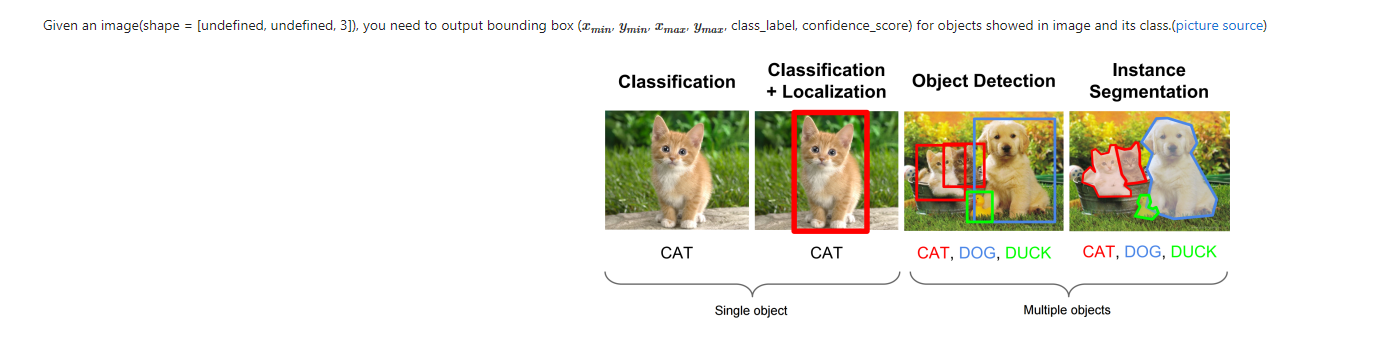

### Data provided

#### Dataset: PASCAL VOC2007
The dataset contains 20 classes. The train/val data has 5012 images containing 12608 annotated objects. We have preprocessed training dataset(5012 images) and testing dataset(4953 images) for you. You can download them on Kaggle.



In [1]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

### Processed data format

The information for each image of training data are recorded in VOCdevkit_train/VOC2007/Annotations. However, we have processed those files for you into one record file: pascal_voc_training_data.txt in which each line records informations of each training images.

The data format of pascal_voc_training_data is:

$[image\_name, xmin_i, ymin_i, xmax_i, ymax_i, class_i]$ (repeat number of objects times)

Elements are separated by space.



In [2]:
training_data_file = open("./dataset/pascal_voc_training_data_aug.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

0_000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
0_000007.jpg 141 50 500 330 6
0_000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
0_000012.jpg 156 97 351 270 6
0_000016.jpg 92 72 305 473 1
0_000017.jpg 185 62 279 199 14 90 78 403 336 12


As you can see, one image may have multiple objects. Another thing to note is, the heights and widths of the images in this datset are different. Therefore, you are suggested to reshape images and ground truth bounding boxes' coordinates into same size.

In this competition, you can implement all kinds of object detection models (R-CNN, Fast-RCNN, Faster-RCNN, YOLOs, SSD,...etc.). Here we provide a simple template based on YOLO(You Only Look Once).

In [3]:
import tensorflow as tf
import numpy as np

2023-11-20 15:07:16.430433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


2023-11-20 15:07:17.537506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 15:07:17.537780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 15:07:17.546206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 15:07:17.546389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-20 15:07:17.546545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data_aug.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages_Aug/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 80

us id: 0000:01:00.0, compute capability: 8.6


### Dataset Loader
We define a class especially to process training data, reading the records from pascal_voc_training_data.txt and follow the steps below to prepare data for our network:

1. Create Dataset using tensorflow data API.
2. In Dataset map function, read images and do preprocessing(ex. resizing , normalization).
3. In Dataset map function, change box information [xmin, ymin, xmax, ymax] coordinates into [xcenter, ycenter, width, height] attributes, which is easier for YOLO model to use.
4. Batch, Shuffle operations.

### 資料集載入器

我們定義了一個專門處理訓練數據的類別，從 `pascal_voc_training_data.txt` 讀取記錄，並按照以下步驟準備數據供我們的網絡使用：

1. 使用 TensorFlow 數據 API 創建資料集。
2. 在資料集的映射函數中，讀取圖像並進行預處理（例如調整大小，歸一化）。
3. 在資料集的映射函數中，將框的信息 [xmin，ymin，xmax，ymax] 座標轉換為 [xcenter，ycenter，width，height] 屬性，這對於 YOLO 模型更容易使用。
4. 進行批次處理和洗牌操作。

In [6]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder= True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

Now we can simply new a `DatasetGenerator` which can provide batches of training data for our model.

### Object Detection Model (YOLO)
Different from Region Proposal based model, YOLO divide an image into cell_size×cell_size (say 7×7) cells, each has fixed number of output prediction boxes(coordinates, class_number, and confidence score). The final prediction would be the boxes with highest confidence score. The prediction of YOLO can be based on the output features extracted by the convolutional layers on the input image, which is actually "look once" on each image.

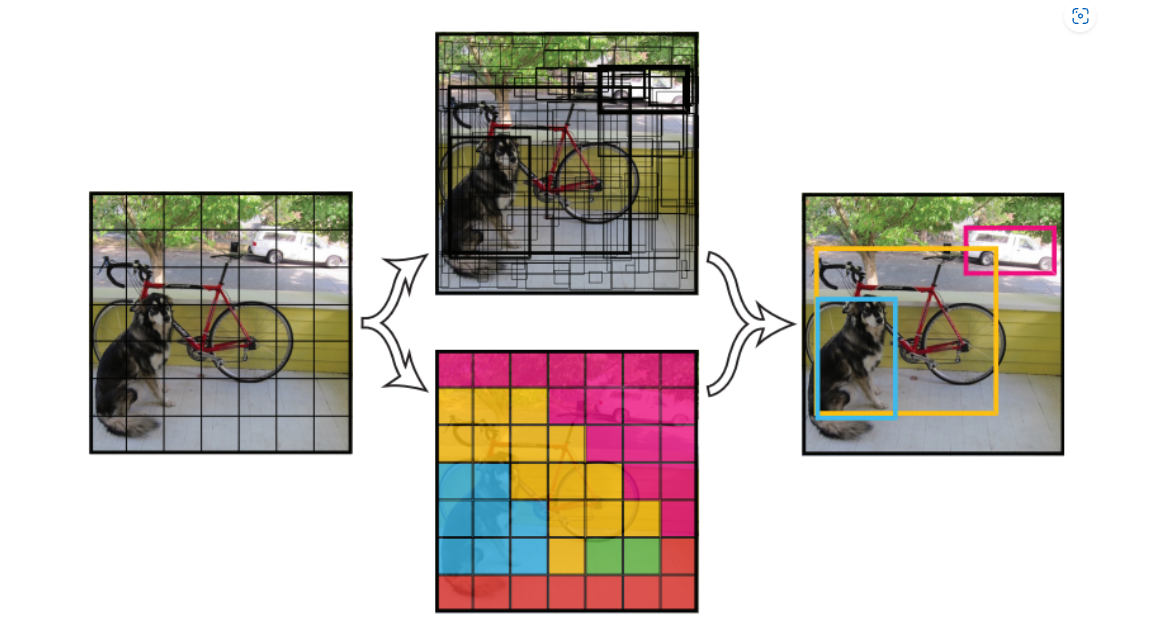


Intersection Over Union(IoU)
The loss calculation of YOLO includes calculating the intersection over union between the predicted boxes and the ground truth boxes. IoU is a common way to evaluate whether the predicted box coordinate is precise enough or not. The calcuation of iou is

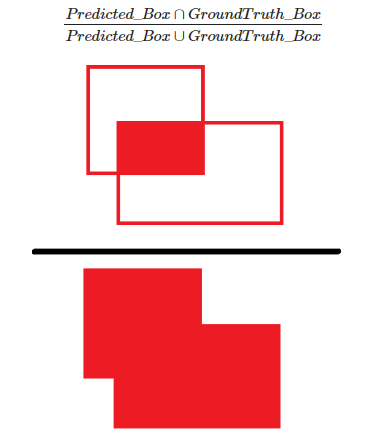

So we would like the IoU of our prediction and the ground the larger the better. In addition, IoU is also used when we evaluate an object detection model is good or not: the prediction is success if the IoU of the predicted box and the ground truth is larger than a threshould.

### Model Architecture
24 convolution layers followed by 2 fully connected layers.
Use a linear activation function for the final layer and all other layers use the following leaky rectified linear activation:

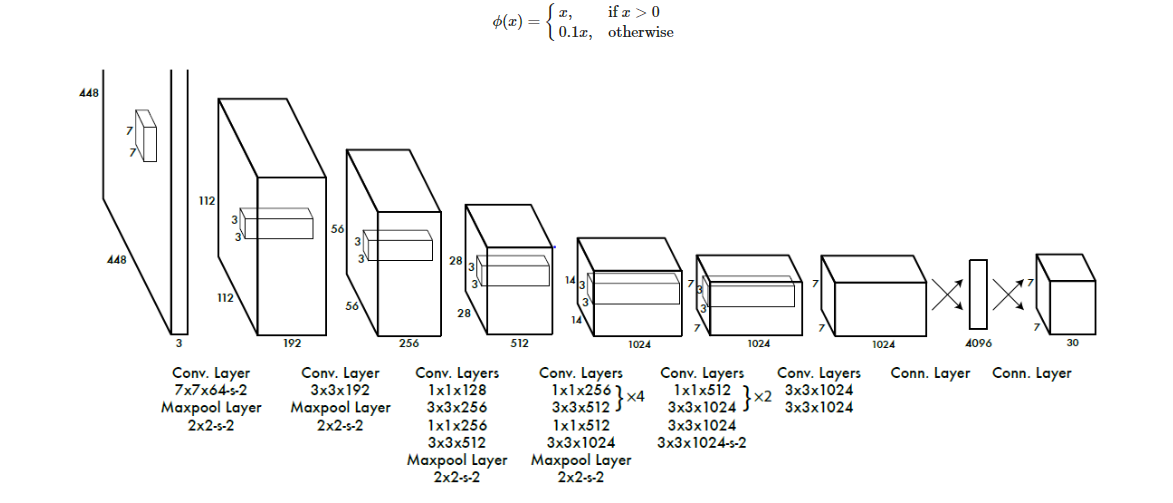


現在，我們可以簡單地創建一個 `DatasetGenerator`，該生成器可以為我們的模型提供訓練數據的批次。

### 物體檢測模型（YOLO）
不同於基於區域提議的模型，YOLO將圖像分為 `cell_size×cell_size`（例如7×7）個單元格，每個單元格具有固定數量的輸出預測框（座標、類別數和信心分數）。最終的預測將是具有最高信心分數的框。YOLO的預測可以基於卷積層在輸入圖像上提取的輸出特徵，實際上是對每個圖像進行一次全局檢測。

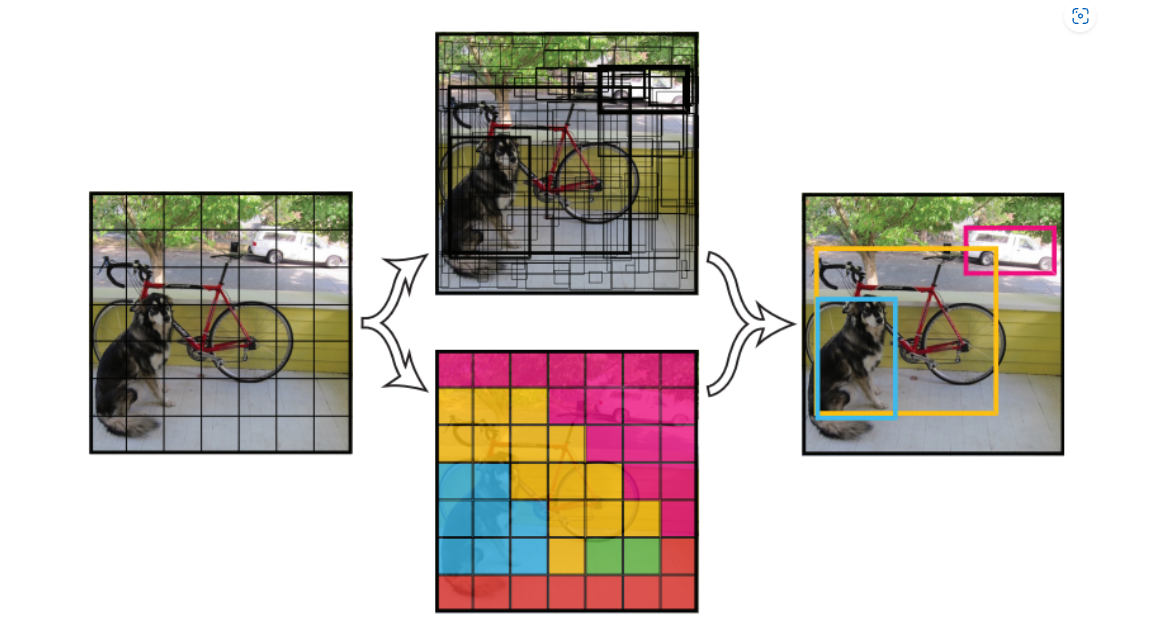

交集和聯集（IoU）
YOLO的損失計算包括計算預測框和實際框之間的交集和聯集。IoU是評估預測框座標是否足夠精確的常見方法。IoU的計算公式為：

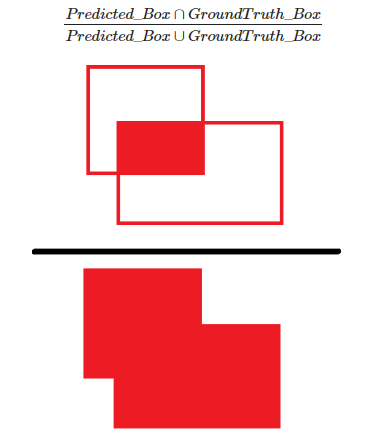

因此，我們希望我們的預測和實際情況的IoU越大越好。此外，當評估物體檢測模型的優劣時，還使用IoU：如果預測框和實際情況的IoU大於某個閾值，則預測成功。

### 模型架構
包括24個卷積層和2個全連接層。
最後一層使用線性激活函數，而其他層使用以下泄漏整流線性激活：

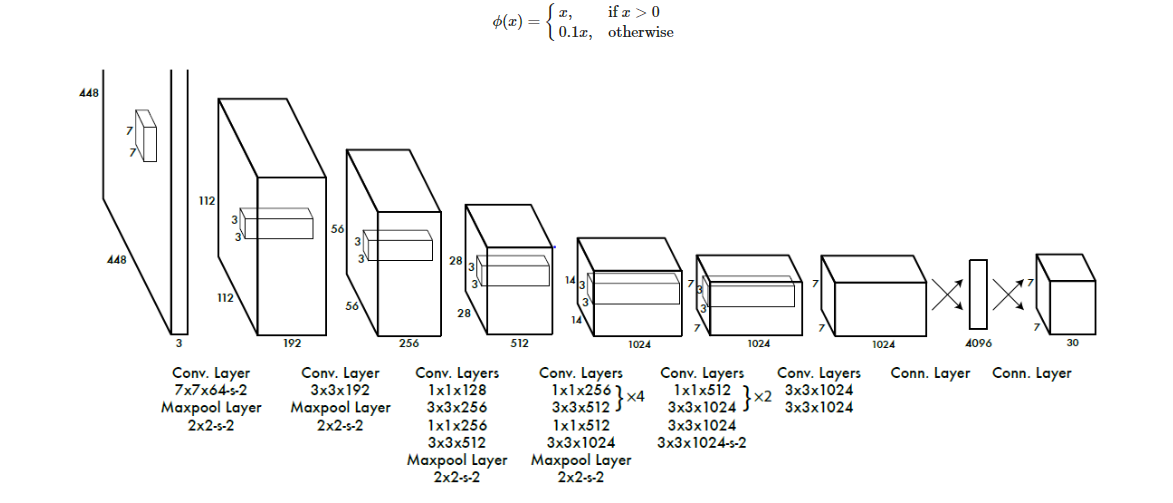

### model

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

In [8]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    return x

In [9]:
# img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# x = conv_leaky_relu(img_inputs, 64, 7, 2)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 192, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 128, 1, 1)
# x = conv_leaky_relu(x, 256, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 256, 1, 1)
# x = conv_leaky_relu(x, 512, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.MaxPool2D()(x)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 512, 1, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 2)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.Flatten()(x)
# x = layers.Dense(4096, 
#                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
# x = layers.LeakyReLU(0.1)(x)
# outputs = layers.Dense(1470, 
#                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

# YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet")(img_inputs)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [10]:
YOLO.summary()


Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      9438208   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 1024)        9438208   
                                                              

### Define loss


In [11]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [12]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    # print("BATCH_SIZE = ", BATCH_SIZE)
    # print('len of object num: ', len(objects_num))
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [13]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

### Start Training
Now we can start training our YOLO model:



In [14]:
dataset = DatasetGenerator().generate()


In [15]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')


In [16]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO-ERIC', max_to_keep=5,
                                     checkpoint_name='yolo')

In [17]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [18]:
from datetime import datetime
from tqdm import tqdm

In [19]:
if (1):
    print("{}, start training.".format(datetime.now()))
    for i in range(EPOCHS):
        train_loss_metric.reset_states()
        ckpt.epoch.assign_add(1)

        for idx, (image, labels, objects_num) in enumerate(dataset):
            train_step(image, labels, objects_num)

        print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

        save_path = manager.save()
        print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2023-11-20 15:07:20.794168, start training.


2023-11-20 15:07:29.251303: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-11-20 15:07:30.003764: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-20 15:07:30.063659: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-20 15:07:30.291046: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-20 15:07:30.291075: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance g

2023-11-20 15:07:40.427848, Epoch 1: loss 22131.21
Saved checkpoint for epoch 1: ./ckpts/YOLO-ERIC/yolo-1
2023-11-20 15:07:51.282179, Epoch 2: loss 59.64
Saved checkpoint for epoch 2: ./ckpts/YOLO-ERIC/yolo-2
2023-11-20 15:08:01.879406, Epoch 3: loss 44.57
Saved checkpoint for epoch 3: ./ckpts/YOLO-ERIC/yolo-3
2023-11-20 15:08:12.452689, Epoch 4: loss 39.95
Saved checkpoint for epoch 4: ./ckpts/YOLO-ERIC/yolo-4
2023-11-20 15:08:23.061064, Epoch 5: loss 36.79
Saved checkpoint for epoch 5: ./ckpts/YOLO-ERIC/yolo-5
2023-11-20 15:08:33.770410, Epoch 6: loss 34.94
Saved checkpoint for epoch 6: ./ckpts/YOLO-ERIC/yolo-6
2023-11-20 15:08:44.502918, Epoch 7: loss 33.74
Saved checkpoint for epoch 7: ./ckpts/YOLO-ERIC/yolo-7
2023-11-20 15:08:55.280492, Epoch 8: loss 32.56
Saved checkpoint for epoch 8: ./ckpts/YOLO-ERIC/yolo-8
2023-11-20 15:09:05.990208, Epoch 9: loss 31.74
Saved checkpoint for epoch 9: ./ckpts/YOLO-ERIC/yolo-9
2023-11-20 15:09:16.725230, Epoch 10: loss 31.02
Saved checkpoint for 

### Predict Test data
After training, we should run testing on the test data images. Since we should output a txt file in similar format as pascal_voc_training_data.txt, we should change the YOLO output box [xcenter, ycenter, width, height] format back to [xmin, ymin, xmax, ymax].

#### Process YOLO's predictions
Below is the function process the output of the YOLO network and return the most confident box and its corresponding class and confidence score.

### 預測測試數據
在訓練之後，我們應該對測試數據圖像進行測試。由於我們應該輸出一個類似於 `pascal_voc_training_data.txt` 格式的文本文件，我們需要將 YOLO 輸出框的 [xcenter，ycenter，width，height] 格式轉換回 [xmin，ymin，xmax，ymax]。

#### 處理 YOLO 的預測結果
下面是處理 YOLO 網絡輸出並返回最自信的框及其對應的類別和信心分數的函數。

In [ ]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

### Build Test dataset Iterator


In [ ]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-3')

2023-11-20 14:51:21.887202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 822083584 exceeds 10% of free system memory.


In [ ]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

#### Make Prediction and Output to txt file

To run the evaluation program we provide, you should output your prediction with this format(similar but different with pascal_voc_training_data.txt)

> image_name   {xmin_i    ymin_i    xmax_i    ymax_i    class_i    confidence_score} (repeat number of objects times)

for each line in the txt file.

**Note:** it is also acceptable if there are multiple lines with same image name(different box predictions).


#### 進行預測並輸出到文本文件

為了運行我們提供的評估程序，您應該以以下格式輸出您的預測（類似但與 `pascal_voc_training_data.txt` 不同）：

> 圖像名稱   {xmin_i    ymin_i    xmax_i    ymax_i    class_i    confidence_score}（重複物件數次）

對於文本文件中的每一行都應該是這樣的格式。

**注意：** 如果有多個行具有相同的圖像名稱（不同的框預測），這也是可以接受的。

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

#### Run Evaluation Metric
Finally, you can use following example code to run the evaluation program we provide and output the csv file. Please submit the csv file onto Kaggle.

The evaluation program calculates mean Average Precision(mAP) of your output boxes. It will first sort your prediction by your confidence score, and get the Precision/Recall curve:

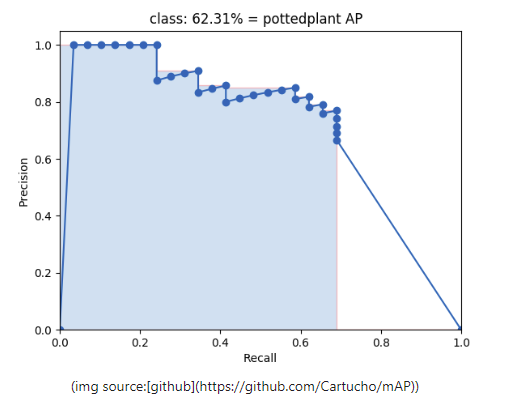

Then the area under this curve is the mAP of this class.

We separated test data into 10 groups, and calculates the mAP of each class for each group. Your goal is to maximize the total mAP score.

#### 執行評估指標

最後，您可以使用以下範例代碼運行我們提供的評估程序，並將結果輸出為 CSV 文件。請將 CSV 文件提交到 Kaggle。

評估程序會計算您輸出框的平均精度（mAP）。它將首先按您的信心分數對預測進行排序，並獲取精度/召回曲線：

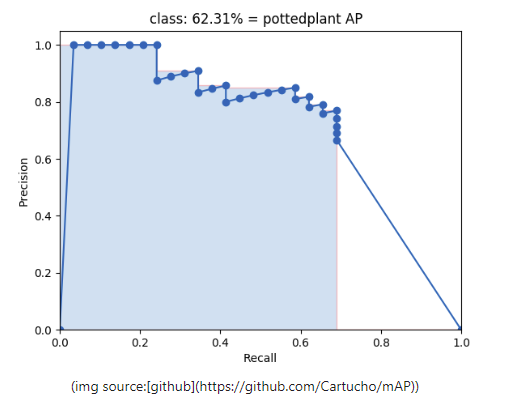

然後，該曲線下的面積就是該類別的 mAP。

我們將測試數據分為10組，並計算每組每個類別的 mAP。您的目標是最大化總 mAP 分數。



In [ ]:
import sys
sys.path.insert(0, './evaluate')

In [ ]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation


#### Visualization
Here we provide a simple code to draw the predicted bounding box and class onto the image and visualize using matplot.

#### 可視化

在這裡，我們提供了一段簡單的代碼，可以將預測的邊界框和類別繪製到圖像上，並使用 Matplotlib 進行可視化。

#### Visualization
Here we provide a simple code to draw the predicted bounding box and class onto the image and visualize using matplot.

#### 可視化

在這裡，我們提供了一段簡單的代碼，可以將預測的邊界框和類別繪製到圖像上，並使用 Matplotlib 進行可視化。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

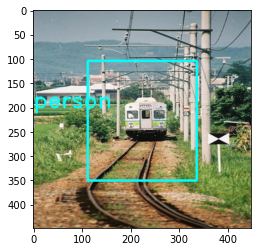

In [ ]:
np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

As you can see, the result of current model needs some improvements. After training, your model shall have at least the capability to output prediction like this:

